In [1]:
# import modules
%matplotlib notebook

import numpy as np
import datetime
import pickle
import copy
from  multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
_colc = matplotlib.rcParams['axes.prop_cycle'].concat(cycler(color=['blue', 'black']))
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

In [2]:
from sci2tex import sci2tex
import chempl
from chempl import (cs, run_one_model, get_total_charge,
                    N_H_to_Av, Av_to_N_H, N_H_to_ngas,
                    Td_from_Av, chem2tex, printFormationDestruction)
phy_params_default = chempl.get_phy_params_default()

In [3]:
def run_one_(p):
    solver.set_solver(solver_id=p['model_id'])
    solver.set_phy_params_by_dict(p['phy_params'])
    t, y = solver.update(p['y'], t=p['t'], dt=p['dt'])
    return {'t': t, 'y': y, 'p': solver.get_all_phy_params()}

# Time-dependent PDR

In [3]:
solver = chempl.ChemModel()
solver.load_reactions(b'rate12_noSurf_only_H2_formation.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)
solver.prepare()

In [22]:
reactions = solver.reactions
for i in range(len(reactions)):
    if reactions[i]['reactants'] == [b'CO'] and reactions[i]['itype'] == 3:
        iCO_photo = i
        break
# This is to include CO self-shielding (in a simplified way)
solver.modify_reaction(iCO_photo, {b'itype': [106]})
del reactions

In [6]:
n_gas = 1e5
G0_UV = 1e5
Av_s = ([_ for _ in np.arange(0, 1, 0.1)] +
        [_ for _ in np.arange(1, 1.8, 0.05)] +
        [_ for _ in np.arange(1.8, 2, 0.1)] +
        [_ for _ in np.arange(2, 6, 0.4)] + [_ for _ in np.arange(6, 21, 2)])
N_H_s = [Av_to_N_H(_) for _ in Av_s]
dL_s = np.hstack(([0], np.diff(N_H_s) / n_gas))
idxH2 = solver.name2idx[b'H2']
idxCO = solver.name2idx[b'CO']
nPos = len(Av_s)

t_max = 1e6 * cs.phy_SecondsPerYear
t_ratio = 1.1
nproc = 4
nLoop = 2000

p_s = [{'t': 0.0, 'dt': 1e-1, 'y': [_ for _ in solver.abundances], 'model_id': i,
        'phy_params': {b'G0_UV': G0_UV, b'n_gas': n_gas, b'T_gas': 1e2,
                       b'v_km_s': 1.0, b'dv_km_s': 1.0, b'Ncol_CO': 0.0, b'Ncol_H2': 0.0,
                       b'Av': Av_s[i], b'Ncol_H': N_H_s[i],
                       b'T_dust': Td_from_Av(Av_s[i], G0=G0_UV)}}
       for i in range(nPos)]

In [7]:
store = []
pool = Pool(processes=nproc)

for iLoop in range(nLoop):
    N_H2 = 0.0
    N_CO = 0.0
    for i in range(nPos):
        N_H2 += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxH2]
        N_CO += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxCO]
        p_s[i]['phy_params'][b'Ncol_H2'] = N_H2
        p_s[i]['phy_params'][b'Ncol_CO'] = N_CO

    res = pool.map(run_one_, p_s)
    store.append(res)

    if all([_['t'] >= t_max for _ in res]):
        break

    for i in range(nPos):
        p_s[i]['y'] = store[-1][i]['y']
        p_s[i]['t'] = store[-1][i]['t']
        p_s[i]['dt'] = p_s[i]['dt'] * t_ratio
        if p_s[i]['t'] + p_s[i]['dt'] > t_max:
            p_s[i]['dt'] = t_max - p_s[i]['t']

In [8]:
with open('PDR_timedependent.pickle', 'wb') as f:
    pickle.dump(store, f)

In [4]:
from matplotlib.collections import LineCollection

def drawWithColorScale(x, vals, ypos=0.2, vmin=-12, vmax=0, lw=10, cmap='plasma',
                       fig=None, ax=None, drawColorbar=False):
    points = np.array([x, [ypos]*len(Av_s)]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(vmin, vmax)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(vals)
    lc.set_linewidth(lw)
    line = ax.add_collection(lc)
    if drawColorbar:
        fig.colorbar(line, ax=ax, aspect=10)

In [5]:
def barPlot(fig, ax, spe, ts_draw, store, solver, idx_s):
    Av_s_s = []
    vals_s = []
    for j in range(len(ts_draw)):
        Av_s, Ncol_H2, X_s = [_ for _ in
                              zip(*[(store[idx_s[i][j]][i]['p'][b'Av'],
                                     store[idx_s[i][j]][i]['p'][b'Ncol_H2'],
                                     store[idx_s[i][j]][i]['y'][solver.name2idx[spe]])
                                    for i in range(nPos)])]
        vals = np.log10(X_s)
        Av_s_s.append(Av_s)
        vals_s.append(vals)
    val_all = np.array(vals_s)
    vmax = np.max(val_all)
    vmax = np.ceil(vmax*2)/2
    vmin = max(np.min(val_all), vmax-5.7)
    for j in range(len(ts_draw)):
        drawWithColorScale(Av_s_s[j], vals_s[j], ypos=ts_draw[j],
                           vmin=vmin, vmax=vmax, lw=2,
                           fig=fig, ax=ax, drawColorbar=(j==len(ts_draw)-1))
    ax.text(0.05, 0.78, chem2tex(spe.decode()), transform=ax.transAxes,
            bbox=dict(facecolor='black', edgecolor='none', alpha=0.2), color='white')

In [35]:
def imPlot(fig, ax, spe, store, solver, levels=100, ylim=(0.4e2,1e6)):
    ny = len(store)
    nx = len(store[0])
    x = [store[0][i]['p'][b'Av'] for i in range(len(store[0]))]
    y = np.array([store[i][0]['t']/cs.phy_SecondsPerYear for i in range(len(store))])
    
    a = np.array([[np.log10(store[i][j]['y'][solver.name2idx[spe]])
                   for j in range(len(store[0]))]
                  for i in range(len(store))])
    xx, yy = np.meshgrid(x, y)
    idx = np.logical_and(yy>=ylim[0], yy<=ylim[1])
    a[np.logical_not(idx)] = np.nan

    vmax = np.max(a[idx])
    vmax = np.ceil(vmax*2)/2
    vmin = max(np.min(a[idx]), vmax-4.7)
    C = ax.contourf(x, y, a, levels, vmin=vmin, vmax=vmax, cmap='plasma')
    for c in C.collections:
        c.set_edgecolor("face")
    
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=4)
    fig.colorbar(C, ax=ax, ticks=tick_locator, aspect=10)

    ax.text(0.05, 0.78, chem2tex(spe.decode()), transform=ax.transAxes, color=(0.8,0.3,0.3))

In [7]:
def addAx(fig, pos, xlabel='Av', ylabel='Time (yr)',
          noXticks=False, noYticks=False, ylim=(0.4e2, 1e6), yticks=(1e2,1e4,1e6)):
    ax = fig.add_axes(pos)
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim((1e-1, 20))
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.set_yticks(yticks)
    if noXticks:
        ax.set_xticklabels([])
    if noYticks:
        ax.set_yticklabels([])
    return ax

<IPython.core.display.Javascript object>


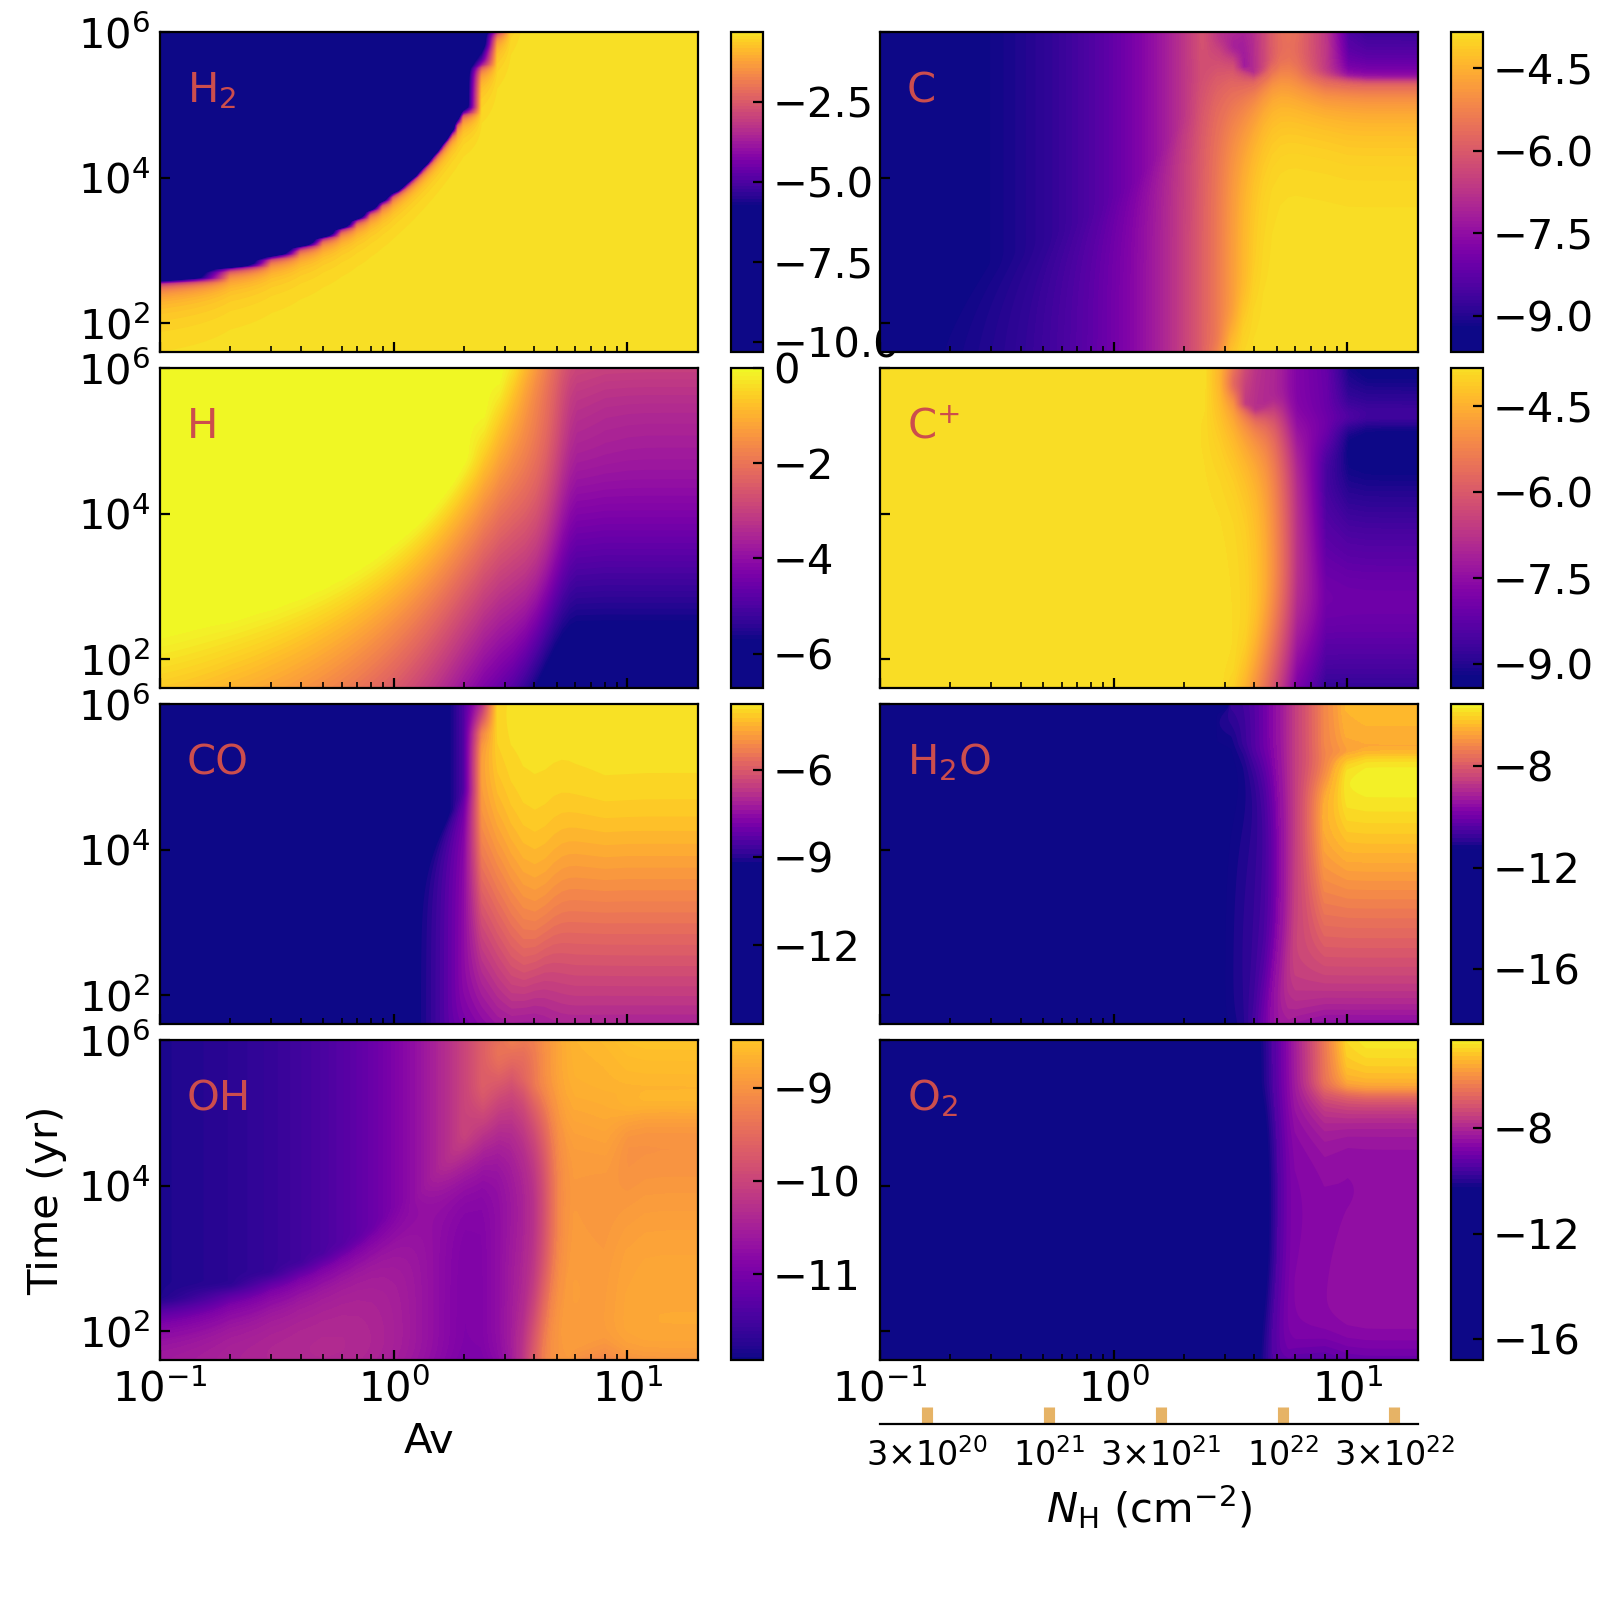

In [13]:
fig = plt.figure(figsize=(8,8))
ax = addAx(fig, [0.1, 0.15, 0.42, 0.2])
imPlot(fig, ax, b'OH', store, solver)
ax = addAx(fig, [0.1, 0.36, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'CO', store, solver)
ax = addAx(fig, [0.1, 0.57, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H', store, solver)
ax = addAx(fig, [0.1, 0.78, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H2', store, solver)

ax = addAx(fig, [0.55, 0.15, 0.42, 0.2], noXticks=False, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'O2', store, solver)
ax = addAx(fig, [0.55, 0.36, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H2O', store, solver)
ax = addAx(fig, [0.55, 0.57, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'C+', store, solver)
ax = addAx(fig, [0.55, 0.78, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'C', store, solver)
axpos = ax.get_position()

botxax = fig.add_axes([axpos.x0,0.11,axpos.x1-axpos.x0,0.1], zorder=-1)
botxax.spines['left'].set_visible(False)
botxax.spines['right'].set_visible(False)
botxax.spines['top'].set_visible(False)
botxax.get_yaxis().set_visible(False)
botxax.set_xlabel('$N_{\\rm H}$ (cm$^{-2}$)')
botxax.set_xlim(ax.get_xlim())
botxax.set_xscale('log')
xtickvals = [3e20, 1e21, 3e21, 1e22, 3e22]
xticks = [N_H_to_Av(_) for _ in xtickvals]
xticklabels = ['$'+sci2tex('{:.1e}'.format(_)).replace('1{\\times} ', '')+'$' for _ in xtickvals]
botxax.set_xticks(xticks)
botxax.set_xticklabels(xticklabels, fontsize=12)
botxax.tick_params(axis='x', color=(0.9,0.7,0.4), length=6, width=4, pad=5)
botxax.minorticks_off()
#plt.savefig('PDR_timeDependent_img.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


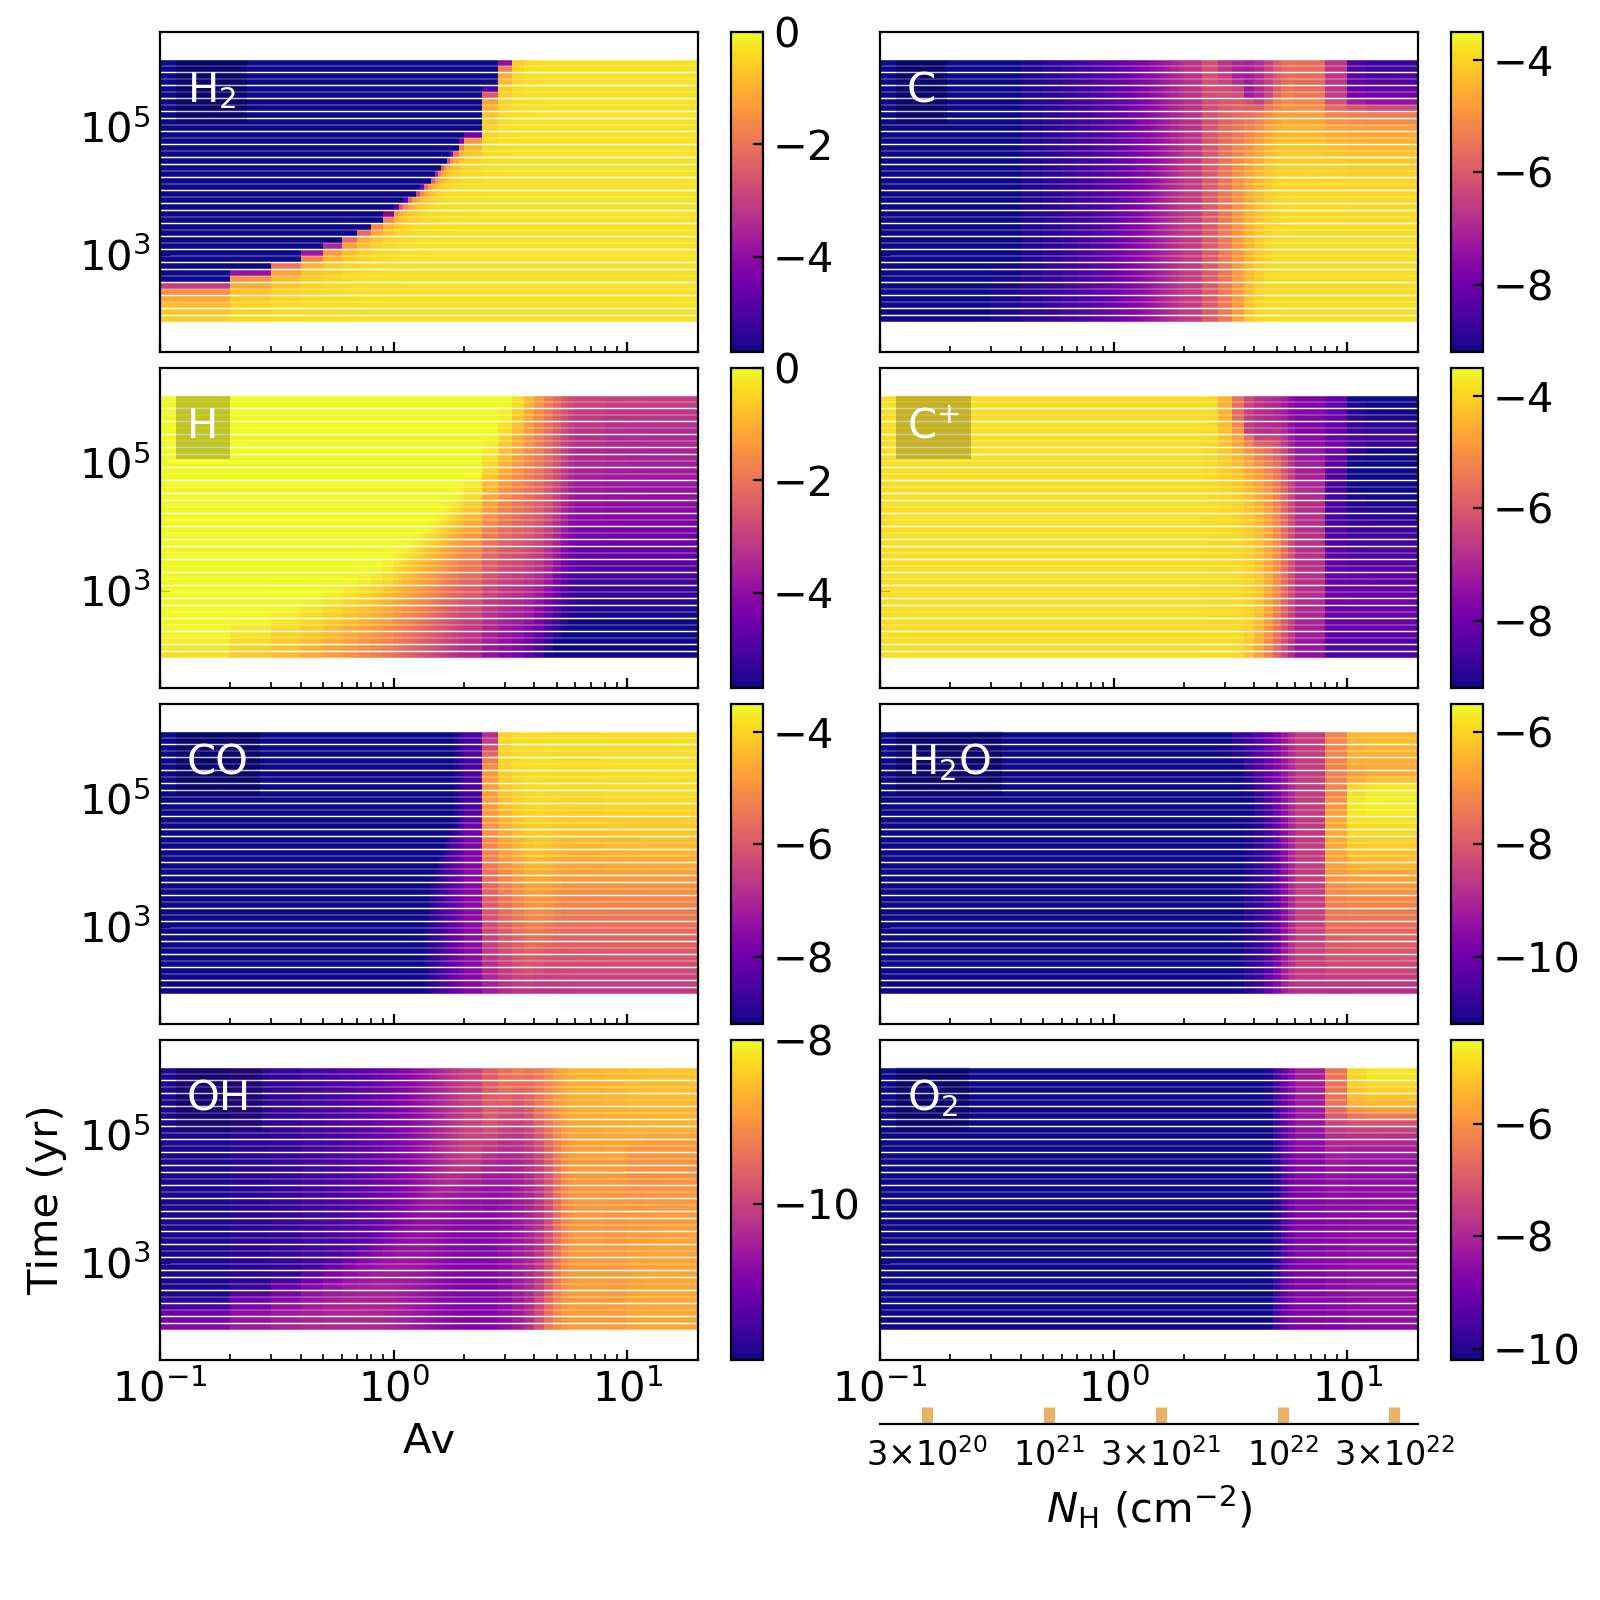

In [199]:
#ts_draw = [1e2, 3.16e2, 1e3, 3.16e3, 1e4, 3.16e4, 1e5, 3.16e5, 1e6]
ts_draw = np.logspace(2, 6, num=40)
idx_s = {i: [np.argmin(np.abs(np.array([store[j][i]['t']/cs.phy_SecondsPerYear
                                        for j in range(len(store))]) - t))
             for t in ts_draw] for i in range(nPos)}

fig = plt.figure(figsize=(8,8))
ax = addAx(fig, [0.1, 0.15, 0.42, 0.2])
barPlot(fig, ax, b'OH', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.1, 0.36, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'CO', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.1, 0.57, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'H', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.1, 0.78, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'H2', ts_draw, store, solver, idx_s)

ax = addAx(fig, [0.55, 0.15, 0.42, 0.2], noXticks=False, noYticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'O2', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.55, 0.36, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'H2O', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.55, 0.57, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'C+', ts_draw, store, solver, idx_s)
ax = addAx(fig, [0.55, 0.78, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
barPlot(fig, ax, b'C', ts_draw, store, solver, idx_s)
axpos = ax.get_position()

botxax = fig.add_axes([axpos.x0,0.11,axpos.x1-axpos.x0,0.1], zorder=-1)
botxax.spines['left'].set_visible(False)
botxax.spines['right'].set_visible(False)
botxax.spines['top'].set_visible(False)
botxax.get_yaxis().set_visible(False)
botxax.set_xlabel('$N_{\\rm H}$ (cm$^{-2}$)')
botxax.set_xlim(ax.get_xlim())
botxax.set_xscale('log')
xtickvals = [3e20, 1e21, 3e21, 1e22, 3e22]
xticks = [N_H_to_Av(_) for _ in xtickvals]
xticklabels = ['$'+sci2tex('{:.1e}'.format(_)).replace('1{\\times} ', '')+'$' for _ in xtickvals]
botxax.set_xticks(xticks)
botxax.set_xticklabels(xticklabels, fontsize=12)
botxax.tick_params(axis='x', color=(0.9,0.7,0.4), length=6, width=4, pad=5)
botxax.minorticks_off()
plt.savefig('PDR_timeDependent.pdf', bbox_inches='tight')

## Use the steady state of a dark cloud as initial condition

In [4]:
solver = chempl.ChemModel()
solver.load_reactions(b'rate12_noSurf_only_H2_formation.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)

p_0 = {'nmax': 2000, 'dt0': 1e-1, 't_ratio': 1.08,
       't_max_s': 1e8*cs.phy_SecondsPerYear, 'model_id': 0,
       'phy_params': {b'T_gas': 20.0, b'T_dust': 20.0, b'n_gas': 1e5, b'chemdesorption_factor': 0.05,
                      b'Av': 10.0, b'Ncol_H2':1e22, b'G0_UV': 1e0, b'chi_cosmicray': 1.0}}
res0 = run_one_model(p_0, model=solver)

Solver: 0 finished: 4.729852 seconds elapsed


In [5]:
y0 = [_ for _ in res0['ys'][-1]]
del solver, res0, p_0

solver = chempl.ChemModel()
solver.load_reactions(b'rate12_noSurf_only_H2_formation.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.setAbundances(y0)
solver.set_phy_params_by_dict(phy_params_default)
solver.prepare()

reactions = solver.reactions
for i in range(len(reactions)):
    if reactions[i]['reactants'] == [b'CO'] and reactions[i]['itype'] == 3:
        iCO_photo = i
        break
solver.modify_reaction(iCO_photo, {b'itype': [106]})
del reactions

n_gas = 1e5
G0_UV = 1e5
Av_s = ([_ for _ in np.arange(0, 1, 0.1)] +
        [_ for _ in np.arange(1, 1.8, 0.05)] +
        [_ for _ in np.arange(1.8, 2, 0.1)] +
        [_ for _ in np.arange(2, 6, 0.4)] + [_ for _ in np.arange(6, 21, 2)])
N_H_s = [Av_to_N_H(_) for _ in Av_s]
dL_s = np.hstack(([0], np.diff(N_H_s) / n_gas))
idxH2 = solver.name2idx[b'H2']
idxCO = solver.name2idx[b'CO']
nPos = len(Av_s)

t_max = 1e6 * cs.phy_SecondsPerYear
t_ratio = 1.1
nproc = 4
nLoop = 2000

p_s = [{'t': 0.0, 'dt': 1e-1, 'y': [_ for _ in solver.abundances], 'model_id': i,
        'phy_params': {b'G0_UV': G0_UV, b'n_gas': n_gas, b'T_gas': 1e2,
                       b'v_km_s': 1.0, b'dv_km_s': 1.0, b'Ncol_CO': 0.0, b'Ncol_H2': 0.0,
                       b'Av': Av_s[i], b'Ncol_H': N_H_s[i],
                       b'T_dust': Td_from_Av(Av_s[i], G0=G0_UV)}}
       for i in range(nPos)]

In [6]:
store = []
pool = Pool(processes=nproc)

for iLoop in range(nLoop):
    N_H2 = 0.0
    N_CO = 0.0
    for i in range(nPos):
        N_H2 += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxH2]
        N_CO += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxCO]
        p_s[i]['phy_params'][b'Ncol_H2'] = N_H2
        p_s[i]['phy_params'][b'Ncol_CO'] = N_CO

    res = pool.map(run_one_, p_s)
    store.append(res)

    if all([_['t'] >= t_max for _ in res]):
        break

    for i in range(nPos):
        p_s[i]['y'] = store[-1][i]['y']
        p_s[i]['t'] = store[-1][i]['t']
        p_s[i]['dt'] = p_s[i]['dt'] * t_ratio
        if p_s[i]['t'] + p_s[i]['dt'] > t_max:
            p_s[i]['dt'] = t_max - p_s[i]['t']

In [21]:
def imPlot(fig, ax, spe, store, solver, levels=200, ylim=(0.4e0,1e6), cb_font_size=10):
    ny = len(store)
    nx = len(store[0])
    x = [store[0][i]['p'][b'Av'] for i in range(len(store[0]))]
    y = np.array([store[i][0]['t']/cs.phy_SecondsPerYear for i in range(len(store))])
    
    a = np.array([[np.log10(store[i][j]['y'][solver.name2idx[spe]])
                   for j in range(len(store[0]))]
                  for i in range(len(store))])
    xx, yy = np.meshgrid(x, y)
    idx = np.logical_and(yy>=ylim[0], yy<=ylim[1])
    a[np.logical_not(idx)] = np.nan

    vmax = np.max(a[idx])
    vmax = np.ceil(vmax*2)/2+0.05
    vmin = max(np.min(a[idx]), vmax-4)
    C = ax.contourf(x, y, a, levels=np.linspace(vmin,vmax,num=levels),
                    vmin=vmin, vmax=vmax, extend='both', cmap='plasma')
    for c in C.collections:
        c.set_edgecolor("face")
    
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb = fig.colorbar(C, ax=ax, ticks=tick_locator, aspect=10)
    cb.ax.tick_params(labelsize=cb_font_size)

    ax.text(0.05, 0.78, chem2tex(spe.decode()), transform=ax.transAxes, color=(0.8,0.3,0.3))
    
def addAx(fig, pos, xlabel='Av', ylabel='Time (yr)',
          noXticks=False, noYticks=False, ylim=(0.4e0, 1e6), yticks=(1e0,1e2,1e4,1e6)):
    ax = fig.add_axes(pos)
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim((1e-1, 20))
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.set_yticks(yticks)
    if noXticks:
        ax.set_xticklabels([])
    if noYticks:
        ax.set_yticklabels([])
    return ax

<IPython.core.display.Javascript object>


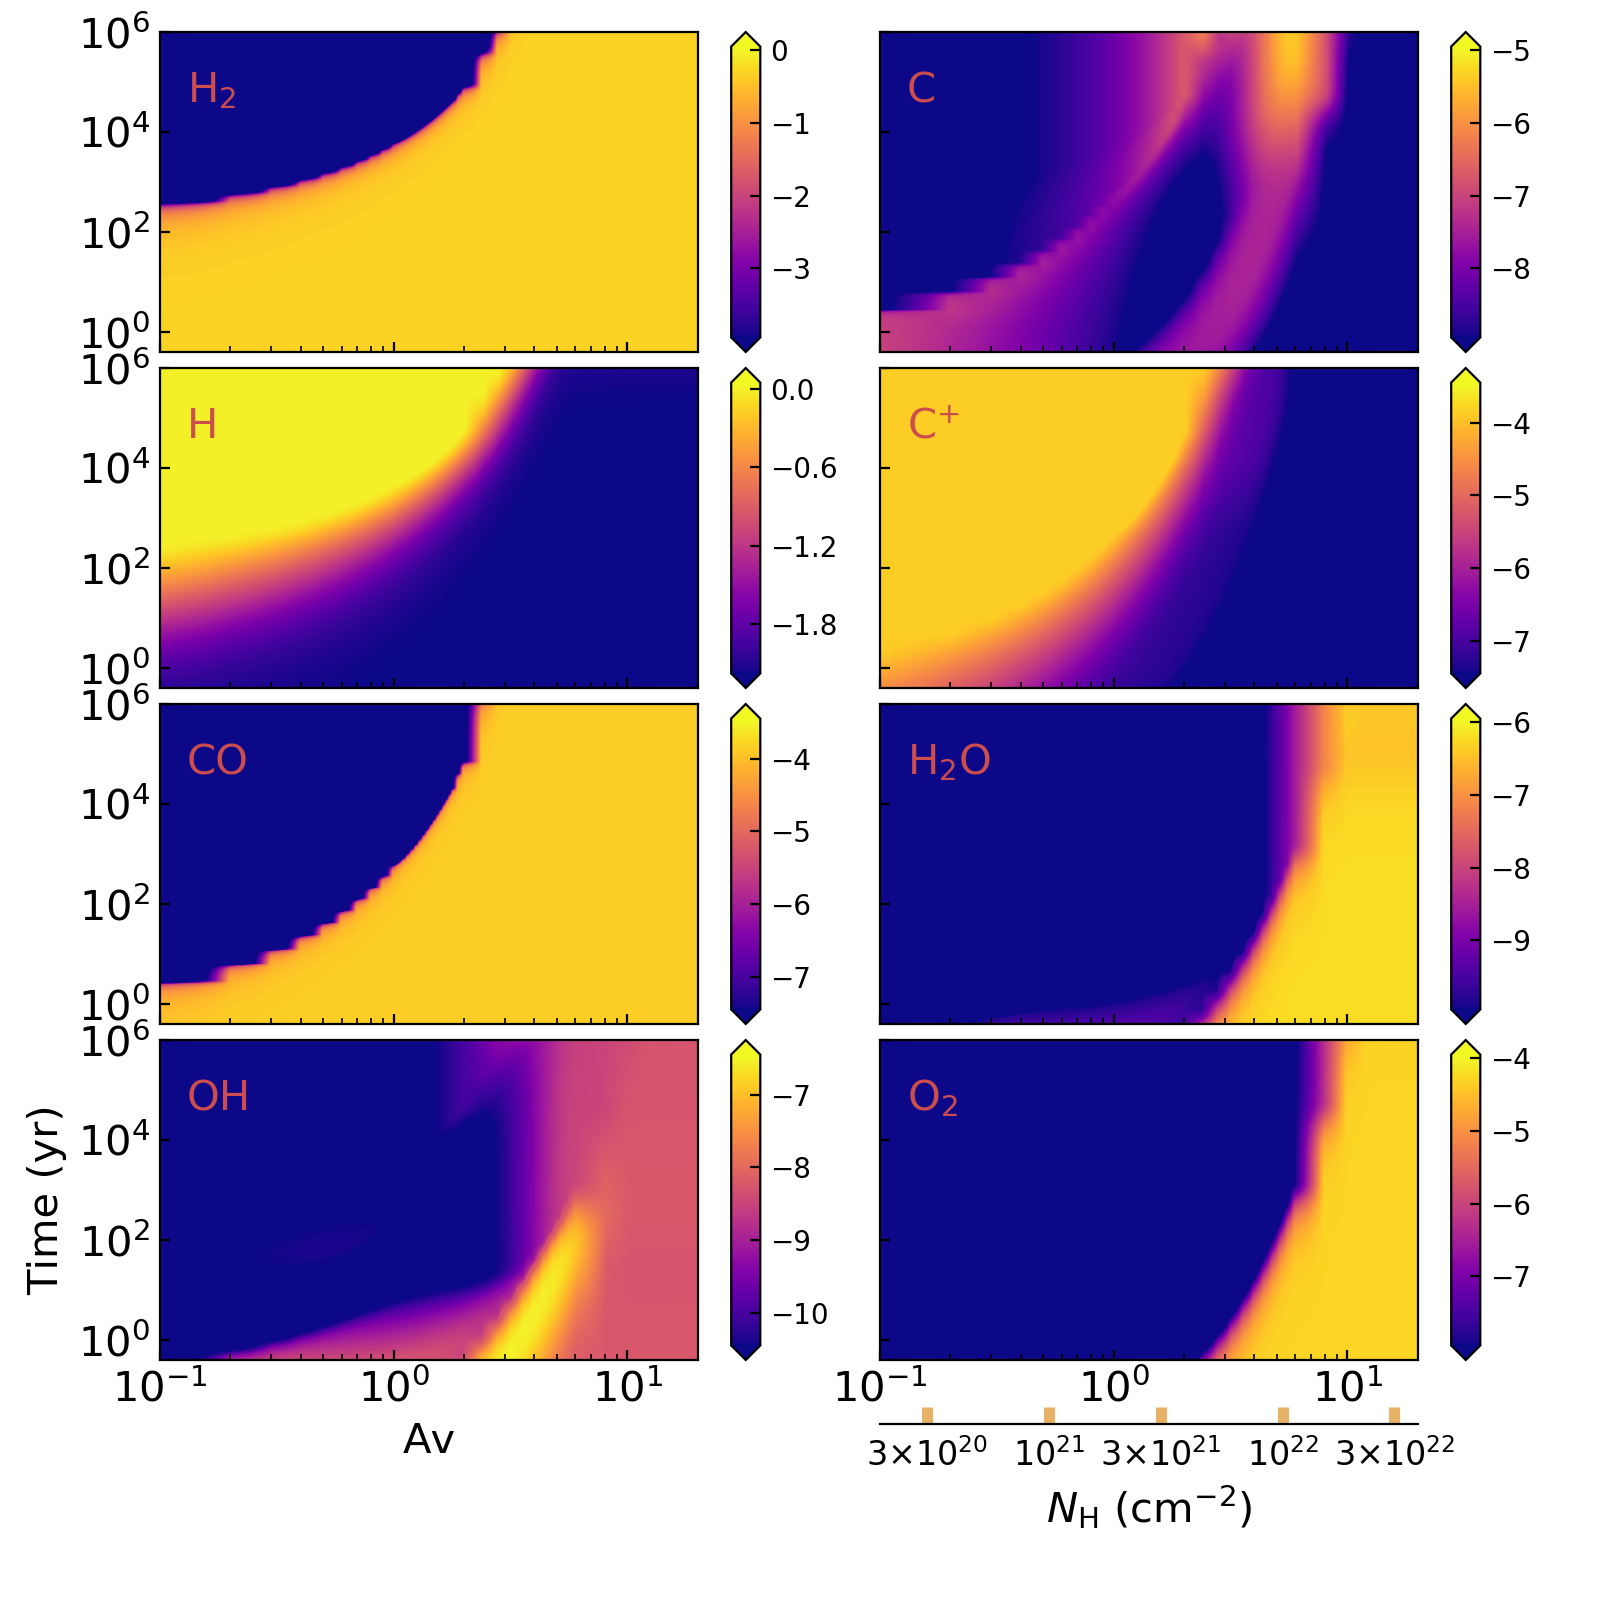

In [22]:
fig = plt.figure(figsize=(8,8))
ax = addAx(fig, [0.1, 0.15, 0.42, 0.2])
imPlot(fig, ax, b'OH', store, solver)
ax = addAx(fig, [0.1, 0.36, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'CO', store, solver)
ax = addAx(fig, [0.1, 0.57, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H', store, solver)
ax = addAx(fig, [0.1, 0.78, 0.42, 0.2], noXticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H2', store, solver)

ax = addAx(fig, [0.55, 0.15, 0.42, 0.2], noXticks=False, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'O2', store, solver)
ax = addAx(fig, [0.55, 0.36, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'H2O', store, solver)
ax = addAx(fig, [0.55, 0.57, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'C+', store, solver)
ax = addAx(fig, [0.55, 0.78, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='')
imPlot(fig, ax, b'C', store, solver)
axpos = ax.get_position()

botxax = fig.add_axes([axpos.x0,0.11,axpos.x1-axpos.x0,0.1], zorder=-1)
botxax.spines['left'].set_visible(False)
botxax.spines['right'].set_visible(False)
botxax.spines['top'].set_visible(False)
botxax.get_yaxis().set_visible(False)
botxax.set_xlabel('$N_{\\rm H}$ (cm$^{-2}$)')
botxax.set_xlim(ax.get_xlim())
botxax.set_xscale('log')
xtickvals = [3e20, 1e21, 3e21, 1e22, 3e22]
xticks = [N_H_to_Av(_) for _ in xtickvals]
xticklabels = ['$'+sci2tex('{:.1e}'.format(_)).replace('1{\\times} ', '')+'$' for _ in xtickvals]
botxax.set_xticks(xticks)
botxax.set_xticklabels(xticklabels, fontsize=12)
botxax.tick_params(axis='x', color=(0.9,0.7,0.4), length=6, width=4, pad=5)
botxax.minorticks_off()
#plt.savefig('PDR_timeDependent_img.pdf', bbox_inches='tight')

In [21]:
plt.savefig('PDR_timeDependent_img_ini.pdf', bbox_inches='tight')

In [12]:
colors = [_['color'] for _ in _colc]
lss = ['-', '--', ':', '-.']

<IPython.core.display.Javascript object>


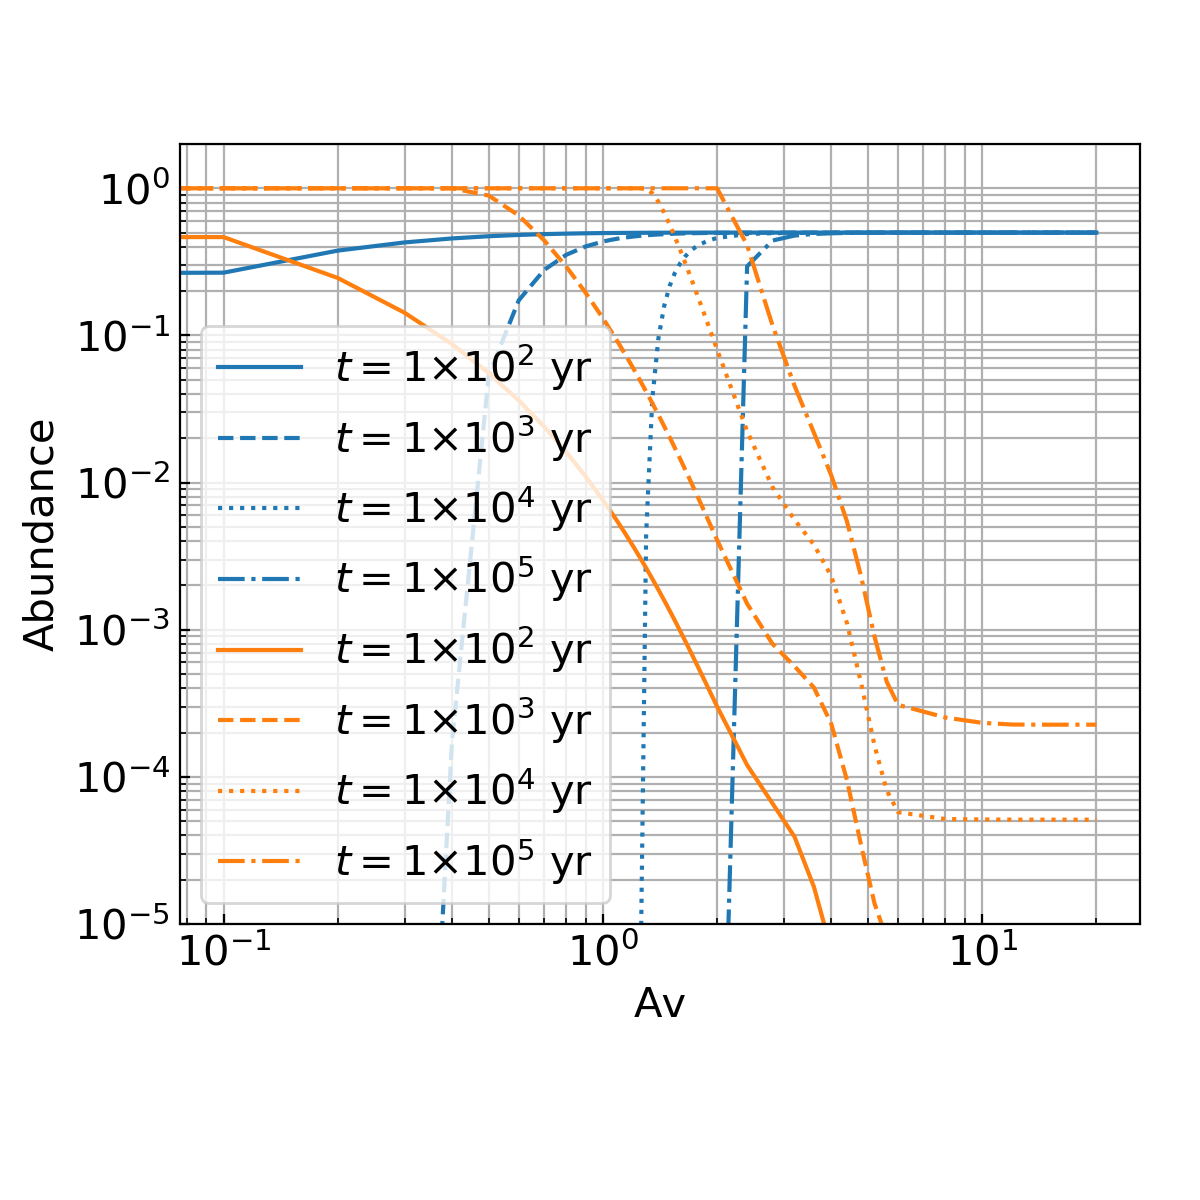

In [14]:
ylim = (1e-5, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.15,0.23,0.8,0.65])
ax.set_xlabel('Av')
ax.set_ylabel('Abundance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ylim)
ax.grid(axis='both', which='both')
ts_draw = [1e2, 1e3, 1e4, 1e5]
idx_s = {i: [np.argmin(np.abs(np.array([store[j][i]['t']/cs.phy_SecondsPerYear
                                        for j in range(len(store))]) - t))
             for t in ts_draw] for i in range(nPos)}

for isp,spe in enumerate([b'H2', b'H']):
    for j in range(len(ts_draw)):
        Av_s, Ncol_H2, X_s = [_ for _ in
                              zip(*[(store[idx_s[i][j]][i]['p'][b'Av'],
                                     store[idx_s[i][j]][i]['p'][b'Ncol_H2'],
                                     store[idx_s[i][j]][i]['y'][solver.name2idx[spe]])
                                    for i in range(nPos)])]
        txt = '$t='+sci2tex('{:.1e}'.format(ts_draw[j]))+'$ yr'
        ax.plot(Av_s, X_s, label=txt, color=colors[isp], ls=lss[j])
ax.legend()

# Start with all H in atomic form

In [37]:
solver = chempl.ChemModel()
solver.load_reactions(b'rate12_noSurf_only_H2_formation.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)
solver.prepare()

In [38]:
solver.setAbundanceByDict({b'H': 1.0, b'H2': 0e-5})

In [39]:
for i in range(len(solver.name2idx)):
    if solver.abundances[i] > 0.0:
        print(solver.idx2name[i], solver.abundances[i])

b'C' 0.00014
b'N' 7.5e-05
b'O' 0.00032
b'H' 1.0
b'Fe' 3e-09
b'Mg' 7e-09
b'Na' 2e-08
b'P' 3e-09
b'Si' 8e-09
b'S' 8e-08
b'Cl' 4e-09
b'F' 2e-08
b'He' 0.09


In [40]:
reactions = solver.reactions
for i in range(len(reactions)):
    if reactions[i]['reactants'] == [b'CO'] and reactions[i]['itype'] == 3:
        iCO_photo = i
        break
solver.modify_reaction(iCO_photo, {b'itype': [106]})
del reactions

In [41]:
n_gas = 1e4
G0_UV = 1e2
Av_s = ([_ for _ in np.arange(0, 1, 0.1)] +
        [_ for _ in np.arange(1, 1.8, 0.05)] +
        [_ for _ in np.arange(1.8, 2, 0.1)] +
        [_ for _ in np.arange(2, 6, 0.4)] + [_ for _ in np.arange(6, 21, 2)])
N_H_s = [Av_to_N_H(_) for _ in Av_s]
dL_s = np.hstack(([0], np.diff(N_H_s) / n_gas))
idxH2 = solver.name2idx[b'H2']
idxCO = solver.name2idx[b'CO']
nPos = len(Av_s)

t_max = 1e7 * cs.phy_SecondsPerYear
t_ratio = 1.5
nproc = 18
nLoop = 4000

p_s = [{'t': 0.0, 'dt': 1e-1, 'y': [_ for _ in solver.abundances], 'model_id': i,
        'phy_params': {b'G0_UV': G0_UV, b'n_gas': n_gas, b'T_gas': 30.0,
                       b'v_km_s': 1.0, b'dv_km_s': 1.0, b'Ncol_CO': 0.0, b'Ncol_H2': 0.0,
                       b'Av': Av_s[i], b'Ncol_H': N_H_s[i],
                       b'T_dust': Td_from_Av(Av_s[i], G0=G0_UV)}}
       for i in range(nPos)]

In [42]:
store = []
pool = Pool(processes=nproc)

for iLoop in range(nLoop):
    N_H2 = 0.0
    N_CO = 0.0
    for i in range(nPos):
        N_H2 += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxH2]
        N_CO += p_s[i]['phy_params'][b'n_gas'] * dL_s[i] * p_s[i]['y'][idxCO]
        p_s[i]['phy_params'][b'Ncol_H2'] = N_H2
        p_s[i]['phy_params'][b'Ncol_CO'] = N_CO

    res = pool.map(run_one_, p_s)
    store.append(res)

    if all([_['t'] >= t_max for _ in res]):
        break

    for i in range(nPos):
        p_s[i]['y'] = store[-1][i]['y']
        p_s[i]['t'] = store[-1][i]['t']
        p_s[i]['dt'] = p_s[i]['dt'] * t_ratio
        if p_s[i]['t'] + p_s[i]['dt'] > t_max:
            p_s[i]['dt'] = t_max - p_s[i]['t']

<IPython.core.display.Javascript object>


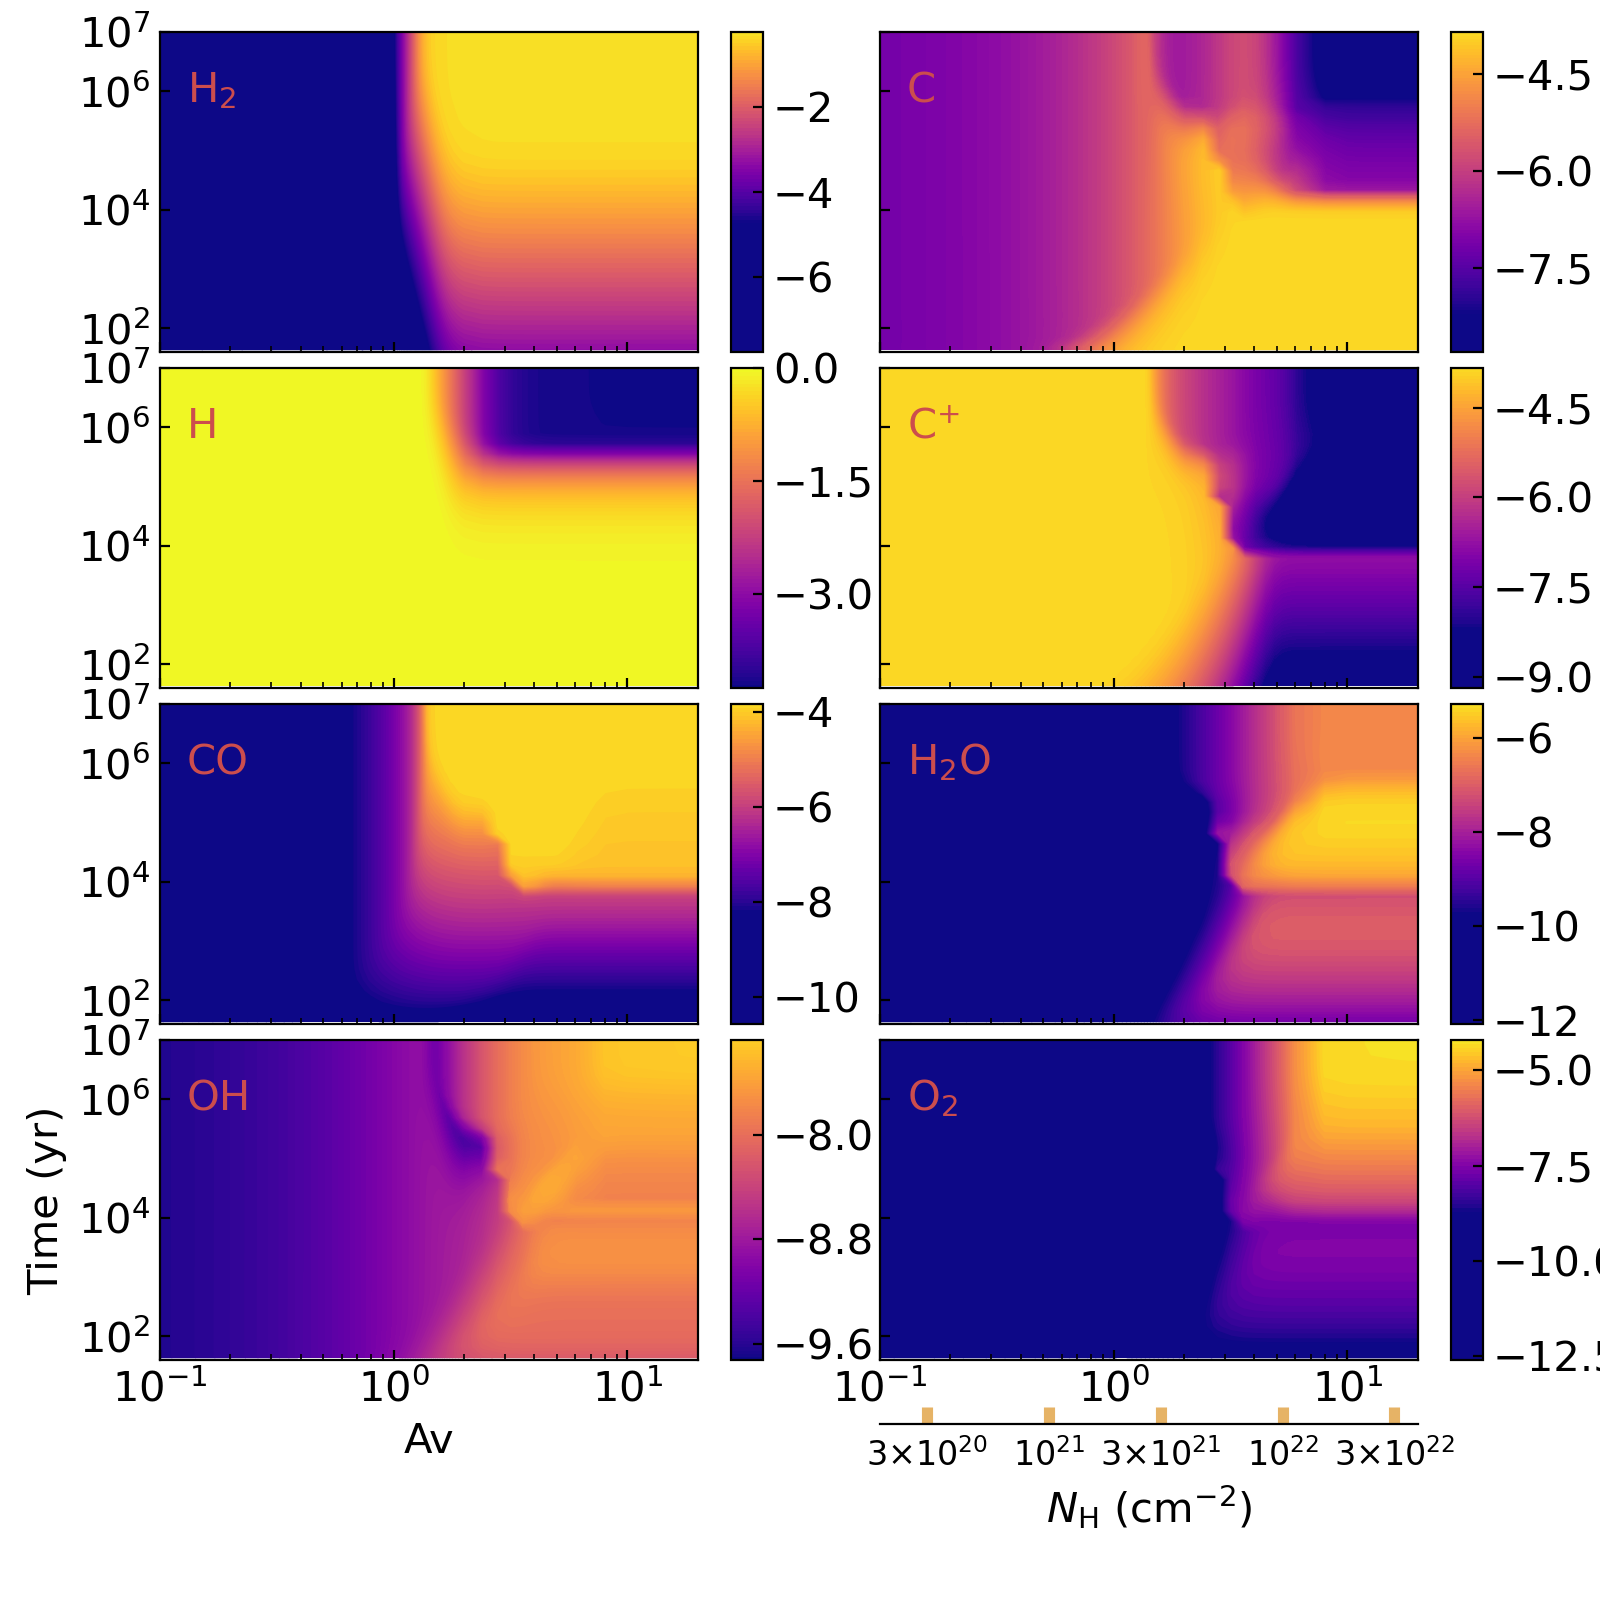

In [43]:
ylim = (0.4e2, 1e7)
yticks = (1e2,1e4,1e6,1e7)
fig = plt.figure(figsize=(8,8))
ax = addAx(fig, [0.1, 0.15, 0.42, 0.2], ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'OH', store, solver, ylim=ylim)
ax = addAx(fig, [0.1, 0.36, 0.42, 0.2], noXticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'CO', store, solver, ylim=ylim)
ax = addAx(fig, [0.1, 0.57, 0.42, 0.2], noXticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'H', store, solver, ylim=ylim)
ax = addAx(fig, [0.1, 0.78, 0.42, 0.2], noXticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'H2', store, solver, ylim=ylim)

ax = addAx(fig, [0.55, 0.15, 0.42, 0.2], noXticks=False, noYticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'O2', store, solver, ylim=ylim)
ax = addAx(fig, [0.55, 0.36, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'H2O', store, solver, ylim=ylim)
ax = addAx(fig, [0.55, 0.57, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'C+', store, solver, ylim=ylim)
ax = addAx(fig, [0.55, 0.78, 0.42, 0.2], noXticks=True, noYticks=True, xlabel='', ylabel='', ylim=ylim, yticks=yticks)
imPlot(fig, ax, b'C', store, solver, ylim=ylim)
axpos = ax.get_position()

botxax = fig.add_axes([axpos.x0,0.11,axpos.x1-axpos.x0,0.1], zorder=-1)
botxax.spines['left'].set_visible(False)
botxax.spines['right'].set_visible(False)
botxax.spines['top'].set_visible(False)
botxax.get_yaxis().set_visible(False)
botxax.set_xlabel('$N_{\\rm H}$ (cm$^{-2}$)')
botxax.set_xlim(ax.get_xlim())
botxax.set_xscale('log')
xtickvals = [3e20, 1e21, 3e21, 1e22, 3e22]
xticks = [N_H_to_Av(_) for _ in xtickvals]
xticklabels = ['$'+sci2tex('{:.1e}'.format(_)).replace('1{\\times} ', '')+'$' for _ in xtickvals]
botxax.set_xticks(xticks)
botxax.set_xticklabels(xticklabels, fontsize=12)
botxax.tick_params(axis='x', color=(0.9,0.7,0.4), length=6, width=4, pad=5)
botxax.minorticks_off()
#plt.savefig('PDR_timeDependent_img.pdf', bbox_inches='tight')

# SO/SO2 abundance ratio

- Simulate the shock condition

In [4]:
solver = chempl.ChemModel()
solver.load_reactions(b'rate12_combined_no_surface_reaction.dat')

solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)

p_0 = {'nmax': 2000, 'dt0': 1e-1, 't_ratio': 1.08,
       't_max_s': 1e6*cs.phy_SecondsPerYear, 'model_id': 0,
       'phy_params': {b'T_gas': 10.0, b'T_dust': 10.0, b'G0_UV': 1.0, b'chi_cosmicray':1e1,
                      b'Av': 10.0, b'n_gas': 1e4, b'Ncol_H2': 1e22}}
res0 = run_one_model(p_0, model=solver)

Solver: 0 finished: 5.393522 seconds elapsed


In [5]:
solver.setAbundances(res0['y'])
solver.setAbundanceByName(b'CO2', 3e-5)
solver.setAbundanceByName(b'H2O', 2e-4)
solver.setAbundanceByName(b'OCS', 2e-6)
solver.setAbundanceByName(b'CH3OH', 4e-6)
solver.setAbundanceByName(b'H2CO', 1e-6)
solver.setAbundanceByName(b'NH3', 2e-5)
solver.setAbundanceByName(b'C2H5', 4e-8)
solver.setAbundanceByName(b'H2S', 2e-6)
solver.setAbundanceByName(b'S', 2e-6)

In [6]:
print([(s, solver.abundances[solver.name2idx[s]]) for s in solver.name2idx
    if solver.abundances[solver.name2idx[s]] > 1e-8])

[(b'C+', 2.2061896427677866e-08), (b'C2H5', 4e-08), (b'CH3OH', 4e-06), (b'CH4', 1.4070195748935324e-08), (b'CO', 9.930598924360123e-05), (b'CO2', 3e-05), (b'E-', 9.808662914656248e-08), (b'F', 1.833096755301698e-08), (b'H', 0.0005702942154576746), (b'H2', 0.49971101005526375), (b'H2CO', 1e-06), (b'H2O', 0.0002), (b'H2S', 2e-06), (b'H3+', 1.0955463011990496e-08), (b'HCO+', 1.6666931397737503e-08), (b'He', 0.08999999502455225), (b'N', 4.783200668436609e-06), (b'N2', 1.828658174873362e-05), (b'NH3', 2e-05), (b'NO', 3.230846483825526e-07), (b'Na+', 1.947784107831564e-08), (b'O', 6.45732235640219e-05), (b'O2', 2.975448847567943e-05), (b'OCS', 2e-06), (b'OH', 8.022323963301258e-07), (b'S', 2e-06), (b'SO', 1.2659451924586936e-08), (b'gC2H2', 2.5765510103995188e-08), (b'gCH4', 7.251092960274219e-08), (b'gCN', 1.9641662093757663e-08), (b'gCO', 4.010486641063508e-05), (b'gCO2', 1.981812965454913e-07), (b'gH2', 3.4410686930262925e-07), (b'gH2O', 1.1484169508676675e-06), (b'gHCN', 1.06881164154810

In [7]:
n = 4
T_s = [30.0, 50.0, 70.0, 90.0]
Av_s = np.array([10.0] * n)
N_H2_s = Av_to_N_H(Av_s) / 2.0
G0_s = [1e0] * n
ngas_s = [5e6] * n

# Set dust2gas_mass to a very small number to simulate the effect of dust destruction

p_s = [{'nmax': 2000, 'dt0': 1e-1, 't_ratio': 1.08,
        't_max_s': 1e6*cs.phy_SecondsPerYear, 'model_id': i,
        'phy_params': {b'T_gas': T_s[i], b'T_dust': 10.0+T_s[i]/2.0, b'G0_UV': G0_s[i], b'chi_cosmicray':1e1,
                       b'dust2gas_mass': 1e-10,
                       b'Av': Av_s[i], b'n_gas': ngas_s[i], b'Ncol_H2': N_H2_s[i]}
       } for i in range(n)]

In [8]:
def run_one_model_(p):
    return run_one_model(p, model=solver)
pool = Pool(processes=4)
store = pool.map(run_one_model_, p_s)

Solver: 0 finished: 8.263167 seconds elapsed
Solver: 1 finished: 9.482829 seconds elapsed
Solver: 3 finished: 10.969319 seconds elapsed
Solver: 2 finished: 11.085404 seconds elapsed


In [9]:
store[0]['y'][solver.name2idx[b'SO']], store[0]['y'][solver.name2idx[b'SO2']]

(7.842261524926531e-07, 5.229259678616756e-06)

<IPython.core.display.Javascript object>


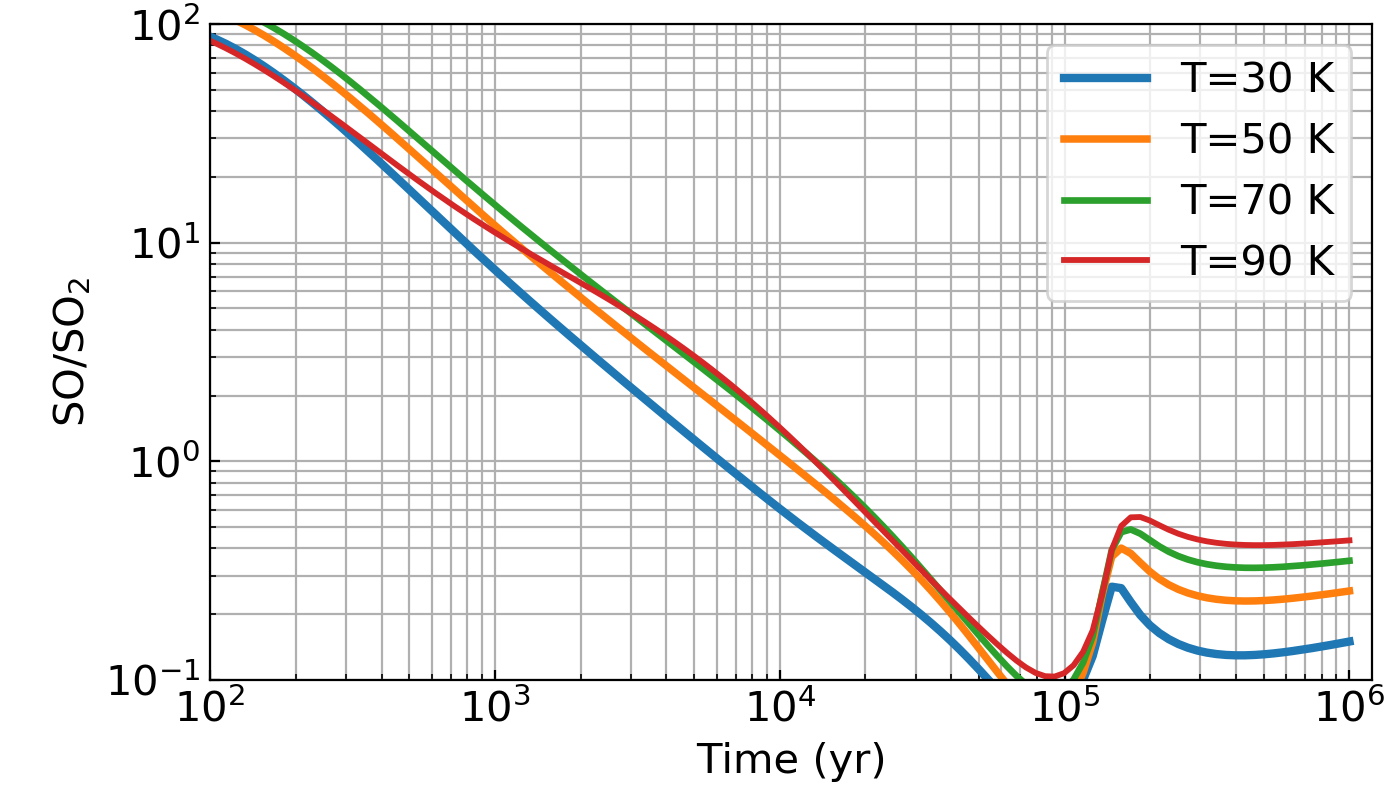

In [10]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0.15,0.15,0.83,0.82])
ax.set_xlabel('Time (yr)')
ax.set_ylabel('SO/SO$_2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2, 1.2e6))
ax.set_ylim((1e-1, 1e2))
ax.grid(axis='both', which='both')

for i,(s,p) in enumerate(zip(store,p_s)):
    ax.plot(np.array(s['ts'])/cs.phy_SecondsPerYear,
            [_[solver.name2idx[b'SO']]/_[solver.name2idx[b'SO2']] for _ in s['ys']],
            label='T={:.0f} K'.format(p['phy_params'][b'T_gas']), lw=3.0-i*0.3)
_ = ax.legend()

<IPython.core.display.Javascript object>


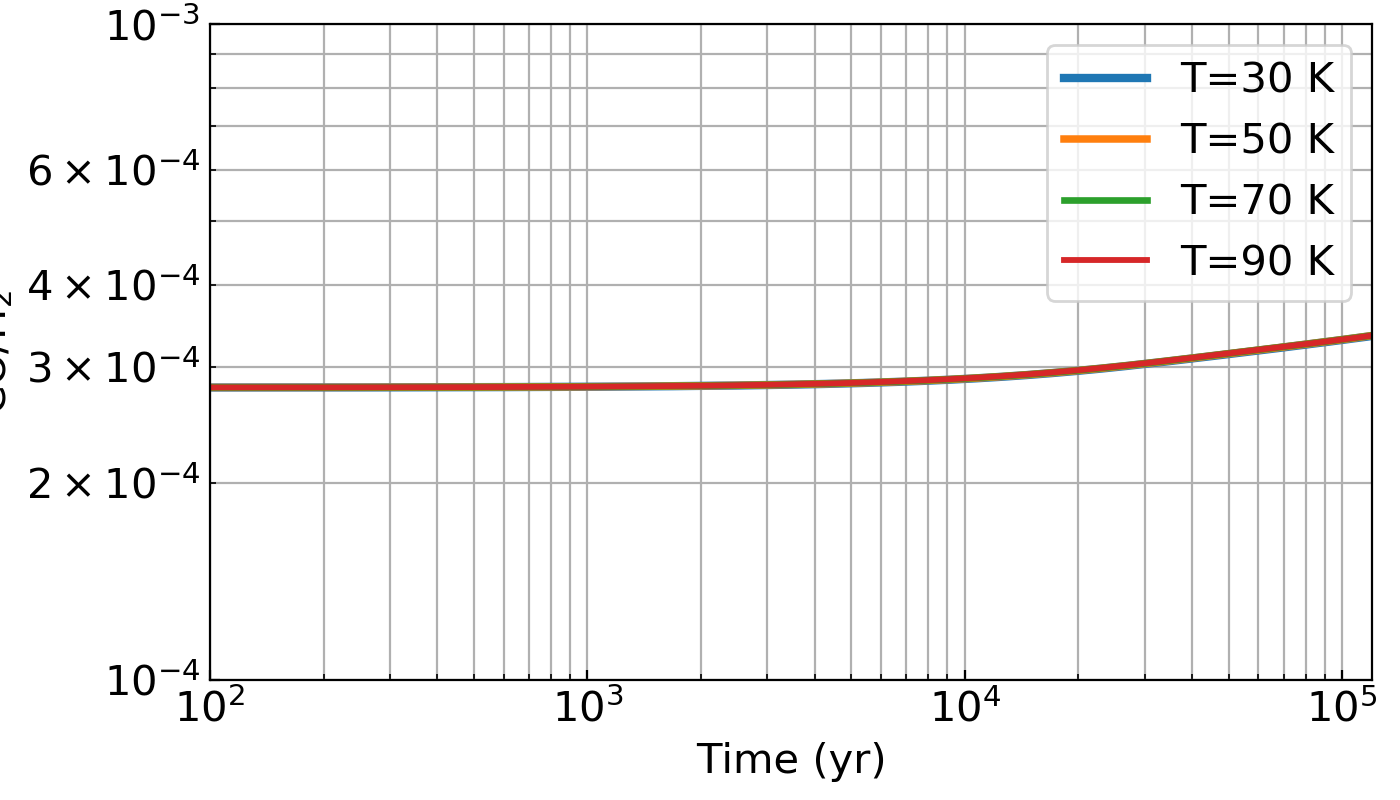

In [21]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0.15,0.15,0.83,0.82])
ax.set_xlabel('Time (yr)')
ax.set_ylabel('CO/H$_2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2, 1.2e5))
ax.set_ylim((1e-4, 1e-3))
ax.grid(axis='both', which='both')

for i,(s,p) in enumerate(zip(store,p_s)):
    ax.plot(np.array(s['ts'])/cs.phy_SecondsPerYear,
            [_[solver.name2idx[b'CO']]/_[solver.name2idx[b'H2']] for _ in s['ys']],
            label='T={:.0f} K'.format(p['phy_params'][b'T_gas']), lw=3.0-i*0.3)
_ = ax.legend()

# How does CF$^+$ change with Av

- CF$^+$ could trace PDR chemistry
- Gas temperature is set to a high value
- Dust temperature lower than gas temperature

In [25]:
solver = chempl.ChemModel()
solver.clear_reactions()
solver.load_reactions(b'rate12_only_gas_phase_isotopized_driven.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)

In [26]:
n = 4
Av_s = np.array([1,2,4,8])
N_H2_s = Av_to_N_H(Av_s) / 2.0
G0_s = [1e1] * n
ngas_s = [1e4] * n

p_s = [{'nmax': 2000, 'dt0': 1e-1, 't_ratio': 1.08,
        't_max_s': 1e7*cs.phy_SecondsPerYear, 'model_id': i,
        'phy_params': {b'T_gas': 300.0, b'T_dust': 50.0, b'G0_UV': G0_s[i],
                       b'Av': Av_s[i], b'n_gas': ngas_s[i], b'Ncol_H2': N_H2_s[i]}
       } for i in range(n)]

In [27]:
def run_one_model_(p):
    return run_one_model(p, model=solver)
pool = Pool(processes=4)
store = pool.map(run_one_model_, p_s)

Solver: 0 finished: 60.816202 seconds elapsed
Solver: 1 finished: 70.58996 seconds elapsed
Solver: 3 finished: 80.56496 seconds elapsed
Solver: 2 finished: 134.997775 seconds elapsed


<IPython.core.display.Javascript object>


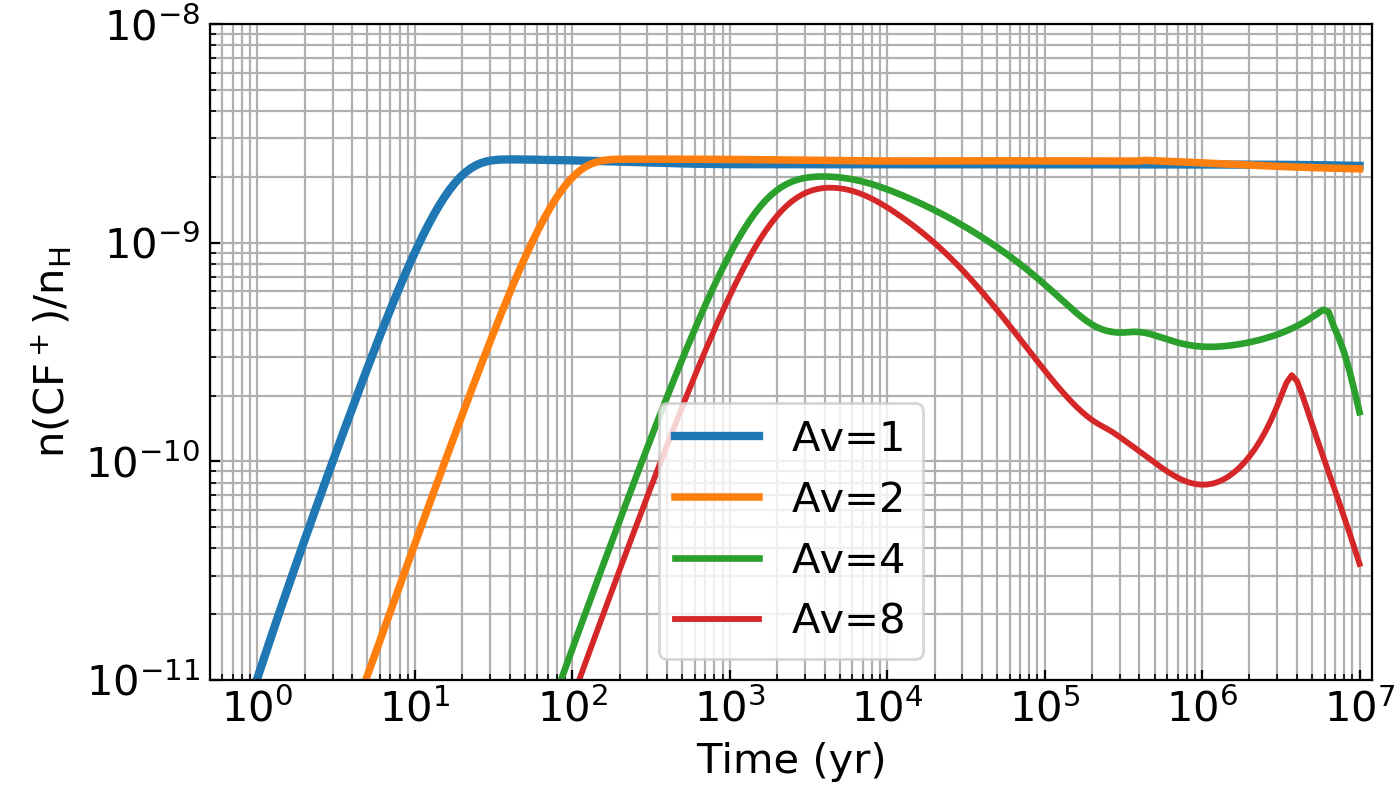

In [28]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0.15,0.15,0.83,0.82])
ax.set_xlabel('Time (yr)')
ax.set_ylabel('n(CF$^+$)/n$_{\\rm H}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((5e-1, 1.2e7))
ax.set_ylim((1e-11, 1e-8))
ax.grid(axis='both', which='both')

for i,(s,p) in enumerate(zip(store,p_s)):
    ax.plot(np.array(s['ts'])/cs.phy_SecondsPerYear,
            [_[solver.name2idx[b'CF+']] for _ in s['ys']],
            label='Av={:.0f}'.format(p['phy_params'][b'Av']), lw=3.0-i*0.3)
_ = ax.legend()

# ---

In [4]:
solver = chempl.ChemModel()
solver.load_reactions(b'rate12_noSurf_only_H2_formation.dat')
solver.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
solver.loadInitialAbundances(b'initial_abundances.dat')
solver.set_phy_params_by_dict(phy_params_default)
solver.prepare()

In [5]:
reactions = solver.reactions
for i in range(len(reactions)):
    if reactions[i]['reactants'] == [b'CO'] and reactions[i]['itype'] == 3:
        iCO_photo = i
        break
# This is to include CO self-shielding (in a simplified way)
solver.modify_reaction(iCO_photo, {b'itype': [106]})
del reactions

In [6]:
n_gas = 1e5
G0_UV = 1e5
Av_s = ([_ for _ in np.arange(0, 1, 0.1)] +
        [_ for _ in np.arange(1, 1.8, 0.05)] +
        [_ for _ in np.arange(1.8, 2, 0.1)] +
        [_ for _ in np.arange(2, 6, 0.4)] + [_ for _ in np.arange(6, 21, 2)])
N_H_s = [Av_to_N_H(_) for _ in Av_s]
dL_s = np.hstack(([0], np.diff(N_H_s) / n_gas))
idxH2 = solver.name2idx[b'H2']
idxCO = solver.name2idx[b'CO']
nPos = len(Av_s)

t_max = 1e6 * cs.phy_SecondsPerYear
t_ratio = 1.1
nproc = 4
nLoop = 2000

p_s = [{'t': 0.0, 'dt': 1e-1, 'y': [_ for _ in solver.abundances], 'model_id': i,
        'phy_params': {b'G0_UV': G0_UV, b'n_gas': n_gas, b'T_gas': 1e2,
                       b'v_km_s': 1.0, b'dv_km_s': 1.0, b'Ncol_CO': 0.0, b'Ncol_H2': 0.0,
                       b'Av': Av_s[i], b'Ncol_H': N_H_s[i],
                       b'T_dust': Td_from_Av(Av_s[i], G0=G0_UV)}}
       for i in range(nPos)]

---

# Misc

$$f(\mu,x,y) = e^{-x \left(y \mu + \sqrt{1-y^2+y^2\mu^2}\right)}$$

$$F(x,y) = \int_{-1}^{1} d\mu\; e^{-x \left(y \mu + \sqrt{1-y^2+y^2\mu^2}\right)}$$

In [132]:
from scipy.integrate import quad

def theFunc(mu, x, y):
    return np.exp(-x * (y*mu + np.sqrt(1 - y*y + (y*mu)**2)))

def tryFunc(x, y):
    w = 1 / (1 + np.exp(10*(y-1)))
    return (np.exp(-x) * (1-w) +
            (1 - np.exp(-2*x) + 2*x) / (4*x) * w)

In [133]:
nx, ny = 30, 400
x_s = np.logspace(-2, 2, num=nx)
y_s = np.linspace(0, 1, num=ny)
res = np.zeros((nx, ny))
for i in range(nx):
    x = x_s[i]
    for j in range(ny):
        y = y_s[j]
        res[i,j] = quad(theFunc, -1, 1, args=(x, y))[0] / 2

<IPython.core.display.Javascript object>


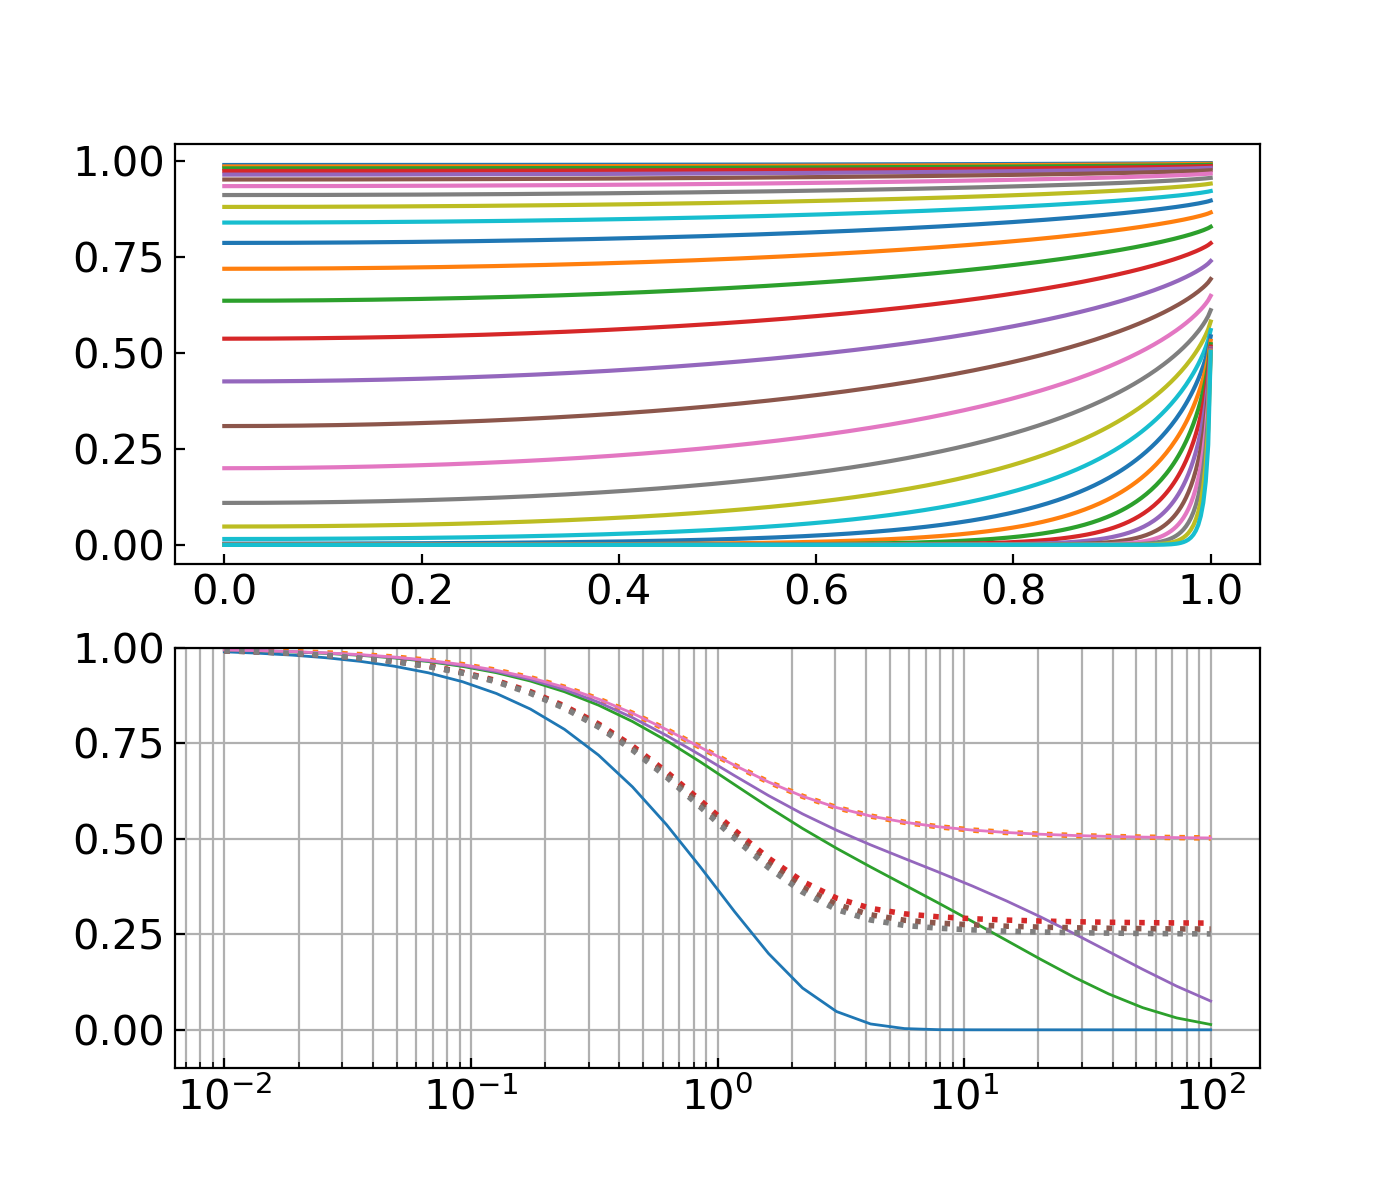

In [134]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(2,1,1)
for i in range(nx):
    ax.plot(y_s, res[i,:])
ax = fig.add_subplot(2,1,2)
ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylim((-0.1,1))
for i in [0,390,395,399]:
    ax.plot(x_s, res[:,i], lw=1)
    ax.plot(x_s, tryFunc(x_s, y_s[i]), ls=':', lw=2)

<IPython.core.display.Javascript object>


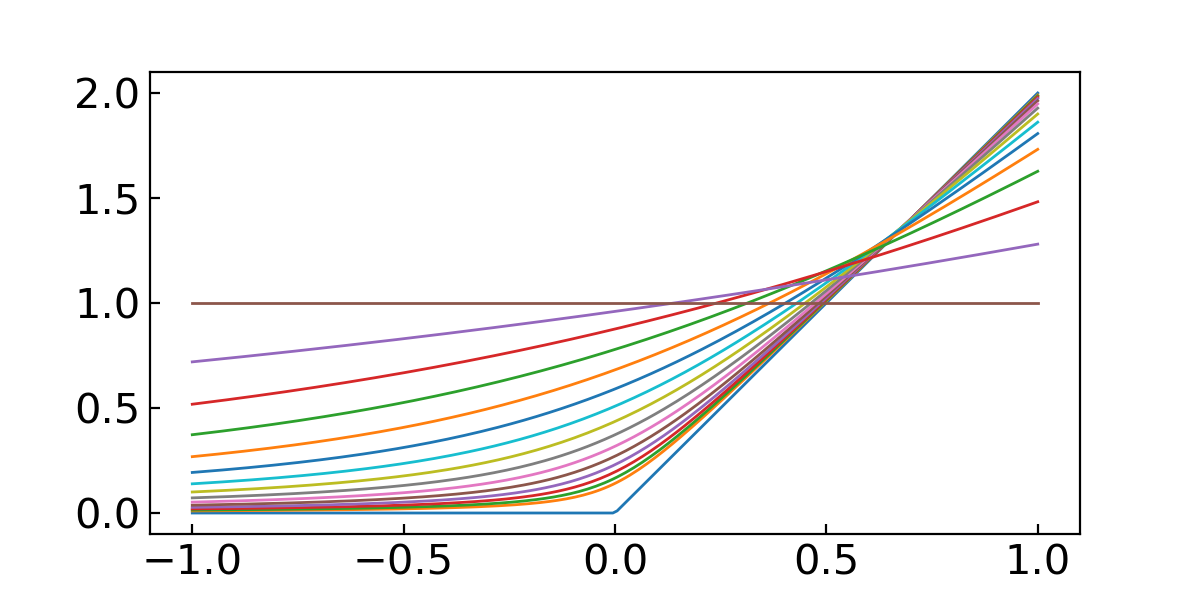

In [156]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
mu_s = np.linspace(-1, 1, num=200)
for y in [1] + [_ for _ in 1-np.logspace(-2,0,num=15)]:
    f = y * mu_s + np.sqrt(1 - y**2*(1- mu_s**2))
    ax.plot(mu_s, f, lw=1)